# Residue Constants

In [50]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os

from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from collections import defaultdict
from poc.analysis.af_residue_constants import rigid_group_atom_positions

## Sample Files

In [51]:
data_dir = 'cif_with_hydrogen'
samples = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
samples = [sample for sample in samples if sample.endswith('.cif')]
samples

['cif_with_hydrogen/9j7m.cif_h.cif',
 'cif_with_hydrogen/2bl2.cif_h.cif',
 'cif_with_hydrogen/4ake.cif_h.cif',
 'cif_with_hydrogen/9q8h.cif_h.cif',
 'cif_with_hydrogen/9f2a.cif_h.cif',
 'cif_with_hydrogen/8ykn.cif_h.cif',
 'cif_with_hydrogen/4hhb.cif_h.cif',
 'cif_with_hydrogen/6m17.cif_h.cif',
 'cif_with_hydrogen/110m.cif_h.cif',
 'cif_with_hydrogen/3cln.cif_h.cif',
 'cif_with_hydrogen/9b7s.cif_h.cif',
 'cif_with_hydrogen/8xnj.cif_h.cif',
 'cif_with_hydrogen/109m.cif_h.cif',
 'cif_with_hydrogen/2hhb.cif_h.cif',
 'cif_with_hydrogen/8zts.cif_h.cif',
 'cif_with_hydrogen/9jwd.cif_h.cif',
 'cif_with_hydrogen/9h44.cif_h.cif',
 'cif_with_hydrogen/1stp.cif_h.cif',
 'cif_with_hydrogen/1ubq.cif_h.cif',
 'cif_with_hydrogen/1a4y.cif_h.cif',
 'cif_with_hydrogen/5t4p.cif_h.cif']

## Process files to new format

In [52]:
amino_acids = []
for sample in samples:
    parsed_cif = MMCIF2Dict(sample)
    chain_before = None
    seq_id_before = None
    current_aa = []
    current_chain = defaultdict(list)
    for i in range(len(parsed_cif['_atom_site.group_PDB'])):
        if parsed_cif['_atom_site.group_PDB'][i] != 'ATOM': continue
        seq_id = parsed_cif['_atom_site.label_seq_id'][i]
        chain = parsed_cif['_atom_site.auth_asym_id'][i]
        if chain != chain_before and chain_before is not None:
            amino_acids.append(*current_chain.values())
            current_chain = defaultdict(list)
        if seq_id != seq_id_before and seq_id_before is not None:
            current_chain[chain].append(current_aa)
            current_aa = []
        aa = parsed_cif['_atom_site.label_comp_id'][i]
        atom_id = parsed_cif['_atom_site.label_atom_id'][i]
        x = float(parsed_cif['_atom_site.Cartn_x'][i])
        y = float(parsed_cif['_atom_site.Cartn_y'][i])
        z = float(parsed_cif['_atom_site.Cartn_z'][i])
        if len(current_aa) == 0:
            current_aa.append(parsed_cif['_atom_site.label_comp_id'][i])
        current_aa.append((atom_id, x, y, z))
        chain_before = chain
        seq_id_before = seq_id
    amino_acids.append(*current_chain.values())

In [53]:
# utility function
def bplot_data_with_stats(data, title: str, label: str, fn: str):
    plt.boxplot(data, vert=False)

    handles = [
        plt.Line2D([0], [0], color='blue', label=f"Mean: {np.mean(data):.10f}"),
        plt.Line2D([0], [0], color='orange', label=f"Median: {np.median(data):.10f}"),
    ]
    plt.legend(handles=handles, loc='upper right')

    plt.title(title)
    plt.xlabel(label)
    plt.savefig(f"plt/{fn}.png", dpi=600)
    plt.show()

## Data stats

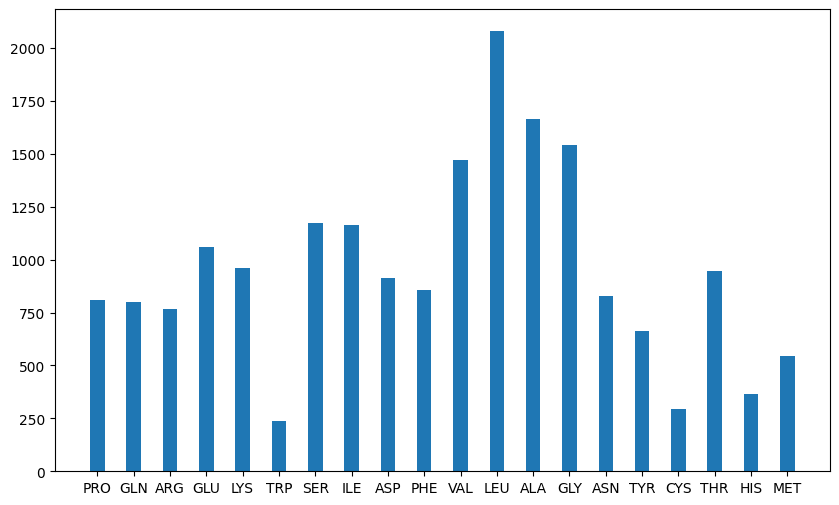

Total analyzed amino acids: 19132


In [54]:
disassembled_acids = defaultdict(int)
for chain in amino_acids:
    for aa in chain:
        disassembled_acids[aa[0]] += 1

total = sum(disassembled_acids.values())
plt.figure(figsize=(10, 6))
plt.bar(disassembled_acids.keys(), list(disassembled_acids.values()), width=0.4)
plt.show()

print('Total analyzed amino acids:', total)


### Alpha Folds Measurements

In [55]:
af_rigid_atom_positions = defaultdict(lambda: defaultdict(float))
for aa, atoms in rigid_group_atom_positions.items():
    for atom in atoms:
        af_rigid_atom_positions[aa][atom[0]] = math.sqrt(atom[2][0]**2 + atom[2][1]**2 + atom[2][2]**2)

## Params

In [56]:
percentile_cut = 0.05

### Ca - Ca distance

In [57]:
ca_ca_distances = []
# af_ca_ca = 3.80209737096
for chain in amino_acids:
    ca_before = None
    for aa in chain:
        for atom in aa[1:]:
            if atom[0] != 'CA': continue
            if ca_before is None:
                ca_before = atom
                continue
            ca_ca_distances.append(
                math.sqrt(
                    (ca_before[1]-atom[1])**2 + (ca_before[2]-atom[2])**2 + (ca_before[3]-atom[3])**2
                )
            )
            ca_before = atom

perc = int(len(ca_ca_distances) * percentile_cut)
ca_ca_distances = np.array(sorted(ca_ca_distances)[perc:-perc])
# ca_ca_distances = np.array(ca_ca_distances)

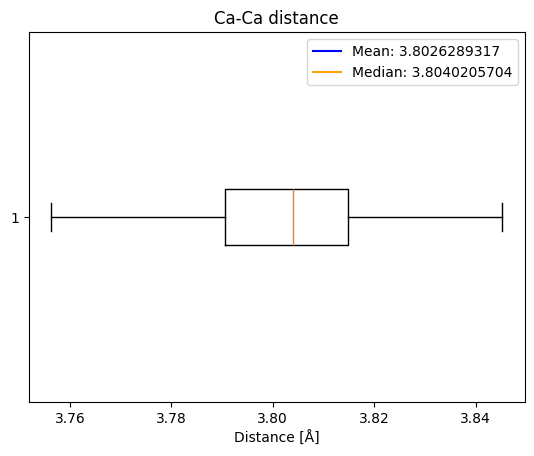

In [58]:
bplot_data_with_stats(ca_ca_distances, 'Ca-Ca distance', 'Distance [Å]', 'distance_ca_ca')

### C - O distance

In [59]:
c_o_distances = []
for chain in amino_acids:
    for aa in chain:
        c = next(atom for atom in aa[1:] if atom[0] == 'C')
        o = next(atom for atom in aa[1:] if atom[0] == 'O')

        c_o_distances.append(
            math.sqrt(
                (c[1]-o[1])**2 + (c[2]-o[2])**2 + (c[3]-o[3])**2
            )
        )

perc = int(len(c_o_distances) * percentile_cut)
c_o_distances = np.array(sorted(c_o_distances)[perc:-perc])

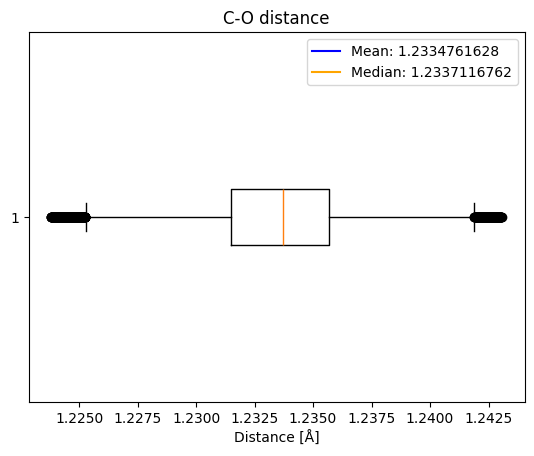

In [60]:
bplot_data_with_stats(c_o_distances, 'C-O distance', 'Distance [Å]', 'distance_c_o')

### C - N distance

In [61]:
c_n_distances = []
for chain in amino_acids:
    c_before = None
    for aa in chain:
        for atom in aa[1:]:
            if atom[0] not in ['C', 'N']: continue
            if c_before is None and atom[0] == 'C':
                c_before = atom
                continue
            if c_before is not None and atom[0] == 'N':
                c_n_distances.append(
                    math.sqrt(
                         (c_before[1]-atom[1])**2 + (c_before[2]-atom[2])**2 + (c_before[3]-atom[3])**2
                    )
                )
                c_before = None

perc = int(len(c_n_distances) * percentile_cut)
c_n_distances = np.array(sorted(c_n_distances)[perc:-perc])

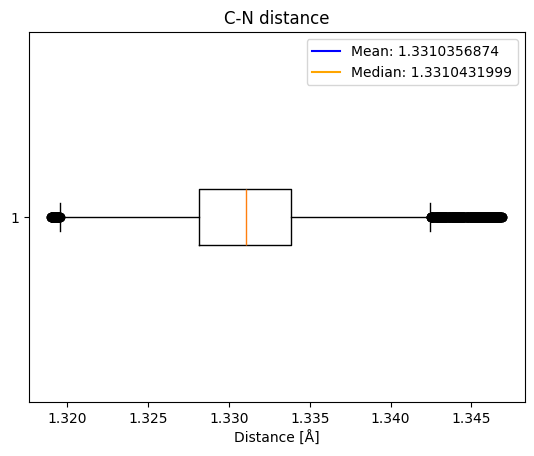

In [62]:
bplot_data_with_stats(c_n_distances, 'C-N distance', 'Distance [Å]', 'distance_c_n')

### N - H distance

In [63]:
n_h_distances = []
for chain in amino_acids:
    c_before = None
    for aa in chain:
        for atom in aa[1:]:
            if atom[0] not in ['N', 'H']: continue
            if c_before is None and atom[0] == 'N':
                c_before = atom
                continue
            if c_before is not None and atom[0] == 'H':
                n_h_distances.append(
                    math.sqrt(
                         (c_before[1]-atom[1])**2 + (c_before[2]-atom[2])**2 + (c_before[3]-atom[3])**2
                    )
                )
                c_before = None

perc = int(len(n_h_distances) * percentile_cut)
n_h_distances = np.array(sorted(n_h_distances)[perc:-perc])

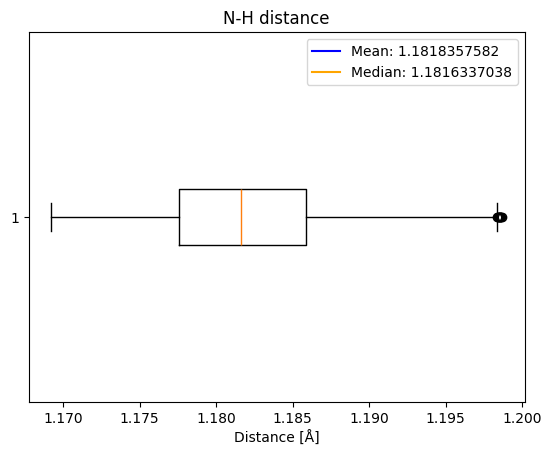

In [64]:
bplot_data_with_stats(n_h_distances, 'N-H distance', 'Distance [Å]', 'distance_n_h')

## Angles

In [65]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def calculate_angle(p1, p2, p3):
    # print('p1', p1)
    # print('p2', p2)
    # print('p3', p3)
    v1 = p1 - p2
    v2 = p3 - p2
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    # print('v1', v1, v1_u)
    # print('v2', v2, v2_u)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

The first two angles are completely within one amino acid, so the data is processed accordingly.

In [66]:
aas = defaultdict(list)
for chain in amino_acids:
    for aa in chain:
        aas[aa[0]].append(aa[1:])


In [67]:
def get_data_for_angle(a1: str, a2: str, a3: str) -> np.array:
    angles = []
    for key, values in aas.items():
        for aa in values:
            n = next(atom for atom in aa if atom[0] == a1)
            ca = next(atom for atom in aa if atom[0] == a2)
            c = next(atom for atom in aa if atom[0] == a3)
            angle = calculate_angle(np.array(n[1:]), np.array(ca[1:]), np.array(c[1:]))
            angles.append(angle)

    perc = int(len(angles) * percentile_cut)
    return np.array(sorted(angles)[perc:-perc])


### N - Ca - C


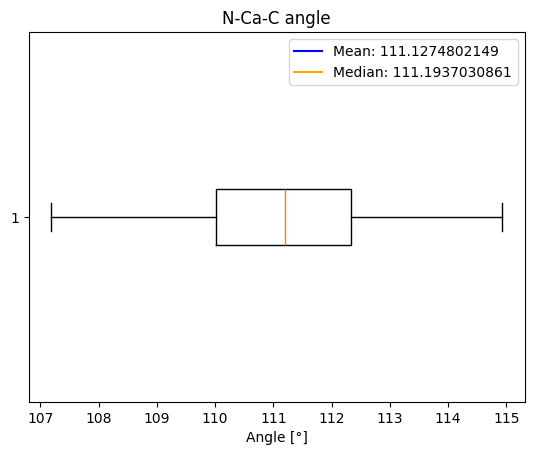

In [68]:
bplot_data_with_stats(get_data_for_angle('N', 'CA', 'C'), 'N-Ca-C angle', 'Angle [°]', 'angle_n_ca_c')

### Ca - C - O

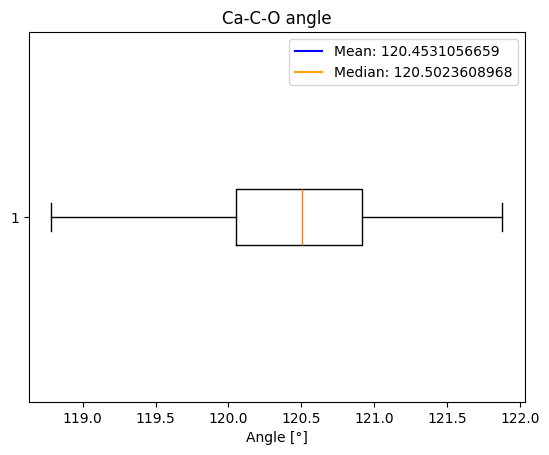

In [69]:
bplot_data_with_stats(get_data_for_angle('CA', 'C', 'O'), 'Ca-C-O angle', 'Angle [°]', 'angle_ca_c_o')

### Ca - C - N

In [70]:
ca_c_n_angles = []
for chain in amino_acids:
    for i in range(len(chain) - 1):
        res1 = chain[i]
        res2 = chain[i + 1]
        ca = next(atom for atom in res1[1:] if atom[0] == 'CA')
        c  = next(atom for atom in res1[1:] if atom[0] == 'C')
        n  = next(atom for atom in res2[1:] if atom[0] == 'N')
        ca_c_n_angles.append(calculate_angle(np.array(ca[1:]), np.array(c[1:]), np.array(n[1:])))
perc = int(len(ca_c_n_angles) * percentile_cut)
ca_c_n_angles = np.array(sorted(ca_c_n_angles)[perc:-perc])

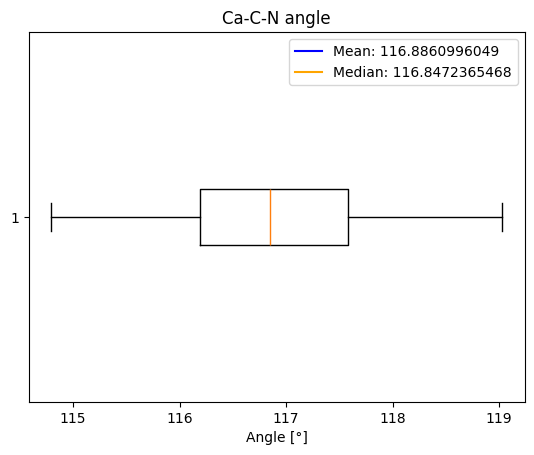

In [71]:
bplot_data_with_stats(ca_c_n_angles, 'Ca-C-N angle', 'Angle [°]', 'angle_ca_c_n')

### C - N - CA

In [72]:
c_n_ca_angles = []
for chain in amino_acids:
    for i in range(len(chain) - 1):
        res1 = chain[i]
        res2 = chain[i + 1]
        ca = next(atom for atom in res1[1:] if atom[0] == 'C')
        c  = next(atom for atom in res2[1:] if atom[0] == 'N')
        n  = next(atom for atom in res2[1:] if atom[0] == 'CA')
        c_n_ca_angles.append(calculate_angle(np.array(ca[1:]), np.array(c[1:]), np.array(n[1:])))
perc = int(len(c_n_ca_angles) * percentile_cut)
c_n_ca_angles = np.array(sorted(c_n_ca_angles)[perc:-perc])

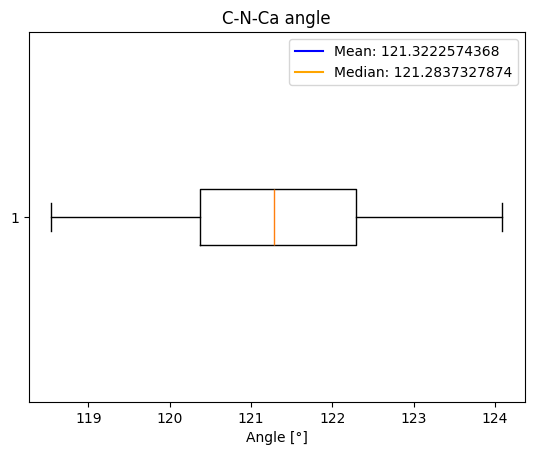

In [73]:
bplot_data_with_stats(c_n_ca_angles, 'C-N-Ca angle', 'Angle [°]', 'angle_c_n_ca')

### C - N - H

In [79]:
c_n_h_angles = []
for chain in amino_acids:
    for i in range(len(chain) - 1):
        res1 = chain[i]
        res2 = chain[i + 1]
        try:
            ca = next(atom for atom in res1[1:] if atom[0] == 'C')
            c  = next(atom for atom in res2[1:] if atom[0] == 'N')
            n  = next(atom for atom in res2[1:] if atom[0] == 'H')
        except StopIteration:
            continue
        c_n_h_angles.append(calculate_angle(np.array(ca[1:]), np.array(c[1:]), np.array(n[1:])))
perc = int(len(c_n_h_angles) * percentile_cut)
c_n_h_angles = np.array(sorted(c_n_h_angles)[perc:-perc])

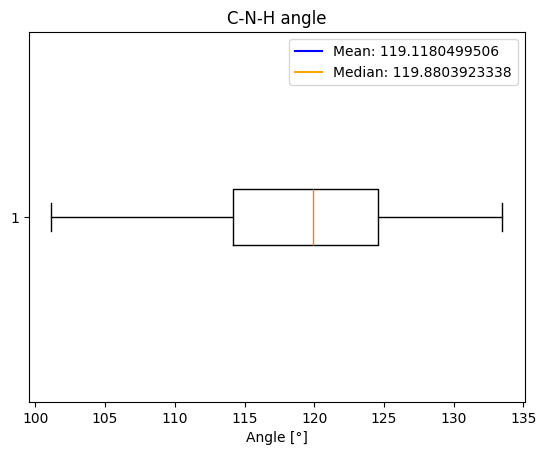

In [80]:
bplot_data_with_stats(c_n_h_angles, 'C-N-H angle', 'Angle [°]', 'angle_c_n_h')